# Neural Networks

In this repository, we will build a neural network from scratch. We will then train it on the Rice Bikes transactions dataset to predict inpatient/outpatient staus from required repairs

## 0. Imports and Data

In [4]:
import numpy as np
import pandas as pd


from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [5]:
def vectorize_feature_data(X):
    """
    Given an (m x n) numpy matrix X representing m samples of n features,
    outputs an iterable of length m where each element is an (n x 1) column vector
    """
    _X = []
    for xi in X:
        _X.append(xi.reshape(-1,1))
    return _X
    

In [6]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

df = df.replace(np.nan,0)

df = df.loc[(df['TotalCost']>0) & 
            (df['RepairCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) # corresponds to two weeks
]


X = df.loc[:, df.columns[14:]].values
y = np.where(df['DayCreated']== df['DayCompleted'], 0, 1)


min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X = vectorize_feature_data(X)


# first we split 70/30 for train / (validation and testing)
# they we equally split validation and testing
# the end result in 70% training, 15% validation, 15% testing
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y, test_size=0.30, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50, random_state = 42)

X[1].shape


(70, 1)

## 1. Neural Net Implementation

In [7]:

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))



def mse(a, y):
    """
    Mean squared error for a single instance of training data
    Parameters:
        - a: post activation value
        - y: true label
    """
    #return .5*sum((a[i] - y[i])**2 for i in range(10))[0]
    return (0.5 * (a -y).T @ (a-y)).item()


In [8]:
def forward_pass(W, B, xi, predict = False, dropout_input = 0.1, dropout_hidden = 0.2):
    """
    Send instance xi through the model described by the weights and biases W,B
    Returns the pre and post activation values of the final layer

    Also supports unique dropout rates for input and hidden layers.
    """
    # pre activation values
    Z = [[0.0]] # dummy value for z_0
    # post activation values
    A = [xi] #a_0 is the input vector x
    L = len(W) - 1
    for i in range(1, L + 1): # go up to L
        
        _W_i = W[i]
        
        # dropout and scale weights accordingly only if not predicting
        if (predict == False):   
            d = dropout_input if i==1 else dropout_hidden
            D = np.random.choice([0,1], size=W[i].shape[1], p=[d, 1-d])
            scale = (1-d)
            _W_i = _W_i * D * scale

        # calculate preactivation value
        z = (_W_i @ A[i-1]) + B[i]
        Z.append(z)            
        
        # calculate postactivation value
        a = sigmoid(z)
        A.append(a)
        
    if predict == False:
        return Z, A
    else:
        return A[-1] #return the last layer if predicting


In [9]:
def MSE(W, B, X, y):
    '''
    Mean squared error for multiple instances
    '''
    
    cost = 0
    
    for xi, yi in zip(X,y):
        
        # feed instance forward to get output activations
        a = forward_pass(W, B, xi, predict = True)
        # compute mse for single instance
        cost += mse(a, yi)
        
    return cost / len(X)

In [10]:
def initialize_weights(layers = [784, 60, 60, 10]):
    """
    Given an iterable describing the number of nodes in each layer of a neural net,
    intialize the weights to by a normal random distribution. 

    If len(layers)=L, returns 2 lists (W,B) describing the weights and biases,
    each of length L-1, where
        W[i].shape = (layers[i+1], layers[i])
        B[i].shape = (layers[i+1], 1)
    """
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]] # dummy values for "weight 0"
    B = [[0.0]] # "bias 0"
    for i in range(1, len(layers)):
        # The scaling factor is something Dr. Davila found in a research paper :)
        scale_factor = np.sqrt(2/layers[i-1])
        
        # for each layer, we want to output layers_i but input layers_(i-1)
        w_temp = np.random.randn(layers[i], layers[i-1])*scale_factor
        b_temp = np.random.randn(layers[i], 1)*scale_factor
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

In [11]:
def accuracy(predict_function, X, y):
    return sum([int(np.rint(predict_function(x)) == y) for x, y in zip(X, y)])/len(y)

In [12]:

class DenseNetwork(object):
    def __init__(self, layers = [784, 60, 60, 10], W= None, B= None):
        self.layers = layers
        if (W is None or B is None):
            self.W, self.B = initialize_weights(layers = self.layers)
        else:
            self.W, self.B = (W,B)
    
    def train(self, X_train, y_train, X_val = [], y_val = [], alpha = 0.046, epochs = 4):
        # Print the initial mean squared error
        self.errors_train_ = [MSE(self.W, self.B, X_train, y_train)]
        self.errors_val_ =   [MSE(self.W, self.B, X_val,   y_val)]
        
        self.accuracy_train_ = [accuracy(self.predict, X_train, y_train)]
        self.accuracy_val_ = [accuracy(self.predict, X_val, y_val)] 
        
        print(f"Starting Cost = {self.errors_train_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        # update the gradient for each of sample_size
        with tqdm(range(epochs), unit="epoch(s)") as pbar:
            for k in pbar:
                #print(f"Epoch {k}")
                # Loop over each (xi, yi) training pair of data.
                for xi, yi in zip(X_train, y_train):
                    # Use the forward pass function defined before
                    # and find the preactivation and postactivation values.
                    Z, A = forward_pass(self.W, self.B, xi)

                    # Per activation layer errors
                    # Stored in a dictionary for clearer interpretation
                    deltas = dict()

                    # Compute the output error 
                    # dC/dz for 1 sample
                    output_error = (A[L] - yi)*d_sigmoid(Z[L]) # activation at last layer, minus label, times d_sigmoid
                    deltas[L] = output_error

                    # Loop from L-1 to 1. Recall the right entry of the range function 
                    # is non-inclusive. 
                    for i in range(L-1, 0, -1): #decrement from L-1 to 1
                        # Compute the node errors at each hidden layer
                        deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                    # Loop over each hidden layer and the output layer to perform gradient 
                    # descent. 
                    for i in range(1, L+1): # up to L
                        self.W[i] -= alpha*deltas[i] @ A[i-1].T
                        self.B[i] -= alpha*deltas[i]

                # Show the user the cost over all training examples
                self.errors_train_.append(MSE(self.W, self.B, X_train, y_train))
                self.errors_val_.append(  MSE(self.W, self.B, X_val,   y_val))
                
                self.accuracy_train_.append(accuracy(self.predict, X_train, y_train))
                self.accuracy_val_.append(accuracy(self.predict, X_val, y_val))
                
                pbar.set_description(desc = f"Epoch Cost = {self.errors_train_[-1]:.5f}")
    
    
    # pretty sure this is a predictor specifically for MNIST 0-9 
    def predict(self, xi):
        #depth = len(self.layers)
        #_, A = forward_pass(self.W, self.B, xi)
        A_L = forward_pass(self.W, self.B, xi, predict=True)
        return A_L[0]
    
    def plot_accuracy(self):
        plt.figure(figsize=(10,8))
        epoch_range = range(0, len(self.accuracy_train_))
        plt.plot(epoch_range, self.accuracy_train_, label="train accuracy")
        plt.plot(epoch_range, self.accuracy_val_, label="validation accuracy")
        plt.title("Accuracy Across Training Epochs")
        plt.xlabel("Epoch(s)")
        plt.ylabel("Accuracy")
        plt.legend()
        
    def plot_error(self):
        plt.figure(figsize=(10,8))
        epoch_range = range(0, len(self.errors_train_))
        plt.plot(epoch_range, self.errors_train_, label="train error")
        plt.plot(epoch_range, self.errors_val_, label="validation error")
        plt.title("Error Across Training Epochs")
        plt.xlabel("Epoch(s)")
        plt.ylabel("MSE")
        plt.legend()

    

## 2. Training and Evaluation

In [13]:
layers = [70, 20, 1]
net1 = DenseNetwork(layers = layers)
net1.train(X_train, y_train, X_val, y_val, alpha =0.1, epochs = 800)

Starting Cost = 0.11461124324128383


Epoch Cost = 0.08085: 100%|██████████| 800/800 [07:22<00:00,  1.81epoch(s)/s]


In [14]:
1-accuracy(net1.predict, X_test, y_test)

0.24291497975708498

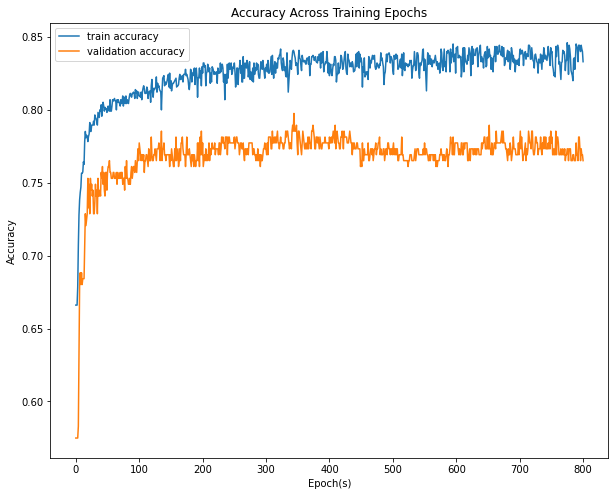

In [15]:
net1.plot_accuracy()

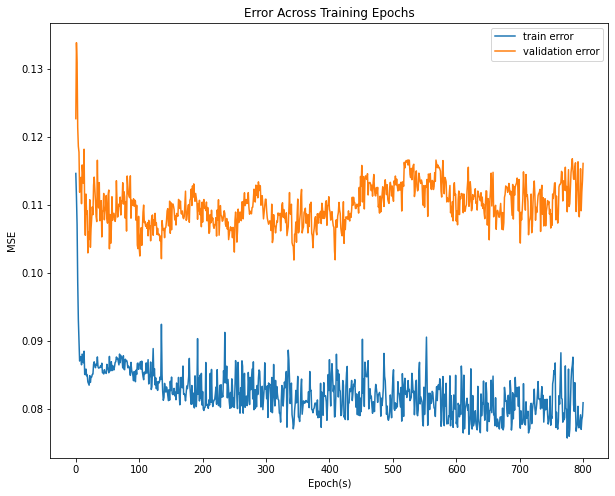

In [16]:
net1.plot_error()